# Introduction

This notebook presents how to train CIFAR-10 dataset on the pretrained VGG16 model. I borrow VGG16 included in tensornets package whose github repo is [here](https://github.com/taehoonlee/tensornets). Also, I will try with the different [implementation](https://github.com/machrisaa/tensorflow-vgg) of the same VGG16 architecture after done with tensornets package. 

The main purpose is to understand the concept of transfer learning and experience with the actual usage. I previously made an notebook to build classical CNN model to train CIFAR-10 dataset, so I can compare between the state of the art CNN model and the very basic CNN model. I am expecting VGG16 will outperform easily. 

# Package Dependency

Before diving in, let's install required packages. If your system doesn't have these listed below, please run the code cell below.

In [ ]:
!pip install h5py
!pip install scipy

# scikit-image package for transforming 
# size of CIFAR-10 image into the input size for VGG16 model.
!pip install scikit-image

# tqdm package for adding progress bar like UI
!pip install tqdm

# Cython package is required to install tensornets
!pip install Cython

In [ ]:
# this will install tensornets package automatically.
# However, if you are on Windows and encountering Visual Studio Build Tool thing, please install it beforehand
!pip install git+https://github.com/taehoonlee/tensornets.git

# CIFAR-10 Dataset Preparation

This is the same step as described in my other github [repo](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow). If you are interested in this step, please read the detailed explanation from the link. Otherwise, you can skip to the next section.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io
import skimage.transform

import tensorflow as tf
import tensornets as nets

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [ ]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [ ]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [ ]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
#     features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [ ]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Load data

In [28]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# Define input (feature) and output (label)

<img src="https://www.safaribooksonline.com/library/view/machine-learning-with/9781786462961/assets/f36fb94f-8824-43f8-a44b-e437972b52ed.png"/>

<p style="text-align:center;">
__VGG16 Architecture__
</p>
<p style="text-align:center;">
(borrowed from [OREILLY](https://www.safaribooksonline.com/library/view/machine-learning-with/9781786462961/21266fa5-9e3b-4f9e-b3c6-2ca27a8f8c12.xhtml))
</p>

VGG models described in the [original paper](https://arxiv.org/pdf/1409.1556.pdf) are trained with images whose size is 224x224x3. This can not be changed, so the input image for the transfer learning task should have the same image size. For the output, CIFAR-10 contains 10 categorical image data which makes the output size 10 as well.

In [23]:
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

# Load VGG16 model, Define loss, train, and accuracy tensor/Operation

The first step is to predefined VGG16 model. 
- if you want to run the model as it is, just pass the input placeholder.
- if you want to train on your own image dataset, set is_training=True, and classes=# of class

nets.VGG16 returns the final layer of the VGG16 which is softmax. If you know, tensorflow comes with tf.nn.softmax_cross_entropy_with_logits function, and this applies softmax and cross entropy together. However, nets.VGG16 returns the layer already applied with softmax, so we need only cross entropy. That can be achieved by tf.losses.softmax_cross_entropy function.

In your choice, you can choose your favorite optimizer. I am going to use Adam optimizer since it is known to work moderate for most of deep learning problems.

In [24]:
logits = nets.VGG16(x, is_training=True, classes=10)
model = tf.identity(logits, name='logits')

loss = tf.losses.softmax_cross_entropy(y, logits)
train = tf.train.AdamOptimizer(learning_rate=0.000001).minimize(loss)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Get Batches

In [25]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

The size of each CIFAR-10 image is 32x32, and VGG16 takes input image sizes 224x224 which is incompatible. Each CIFAR-10 image should be resized so that it can be fed into the VGG16 model. 

skimage.transform.resize function does the trick. It takes parameters..
- takes a numpy matrix representation of an image
- image size to be transformed


In [26]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    tmpFeatures = []
    
    for feature in features:
        tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
        tmpFeatures.append(tmpFeature)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(tmpFeatures, labels, batch_size)

# Get inputs for validation

The same process from load_preprocess_training_batch is applied.

In [29]:
tmpValidFeatures = []

for feature in valid_features:
    tmpValidFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpValidFeatures.append(tmpValidFeature)
    
tmpValidFeatures = np.array(tmpValidFeatures)

5,000 images in a batch is huge to be trained. If you have a very high-end GPU card, you can try more images, but I will go with only 100 of them. By the way, you can also run the batch validation process and calculate the mean.

In [30]:
print(tmpValidFeatures.shape)
# tmpValidFeatures = tmpValidFeatures[:100]
# valid_labels = valid_labels[:100]
# print(tmpValidFeatures.shape)

(5000, 224, 224, 3)


# Print Stats of Accuracy

In [31]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

# Hyper-parameters

In [32]:
epochs = 20
batch_size = 32

# Training

In [ ]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(train, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(tmpValidFeatures, valid_labels, batch_size):
#                 print(batch_valid_features.shape, ', ', batch_valid_labels.shape)
                valid_acc += sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
            
            tmp_num = tmpValidFeatures.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.178400
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.410800
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.515600
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.563800
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.600600
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.636200
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.658000
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.675600
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.683200
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.690400
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.700400
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.730200
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.745400
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.749600
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.763800
Epoch  

In [20]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=10, ncols=3)
#     fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

#     print('predictions: ', predictions)
    
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(pred_indicies)]
        
        is_match = 'False'        
        
#         if image_i < 3:
#             axies[image_i][0].imshow(feature)
#             axies[image_i][2].set_yticks(ind + margin)
#             axies[image_i][2].set_yticklabels(pred_names[::-1])
#             axies[image_i][2].set_xticks([0, 0.5, 1.0])
        
        
        
        if np.argmax(pred_indicies) == label_id:
            is_match = 'True'
            
        print('[{}] ground truth: {}, predicted result: {} | {}\n'.format(image_i, correct_name, pred_name, is_match))
#             axies[image_i][0].imshow(feature*255)
#             axies[image_i][0].set_title(correct_name)
#             axies[image_i][0].set_axis_off()

#             axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
#             axies[image_i][1].set_yticks(ind + margin)
#             axies[image_i][1].set_yticklabels(pred_names[::-1])
#             axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [4]:
test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.8938097133757962

[0] ground truth: automobile, predicted result: automobile | True

[1] ground truth: deer, predicted result: cat | False

[2] ground truth: frog, predicted result: airplane | False

[3] ground truth: truck, predicted result: airplane | False

[4] ground truth: cat, predicted result: automobile | False

[5] ground truth: horse, predicted result: airplane | False

[6] ground truth: ship, predicted result: airplane | False

[7] ground truth: horse, predicted result: airplane | False

[8] ground truth: deer, predicted result: airplane | False

[9] ground truth: truck, predicted result: airplane | False



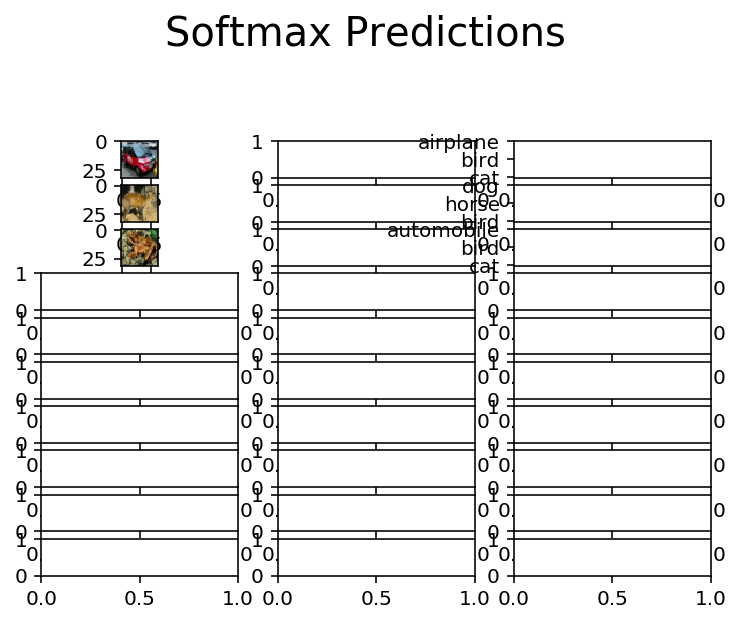

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
#         saver = tf.train.Saver()
#         sess.run(tf.global_variables_initializer())
#         saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)